# Load Datasets

We will be looking at ETH data from March 1, 2017 to November 4, 2017.

Data is taken from https://www.investing.com/currencies/eth-usd, https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory/data, and https://etherscan.io/, and https://github.com/

## Load Ether data

In [1]:
%matplotlib inline

import pandas as pd
import datetime as dt

ether_df = pd.read_csv(filepath_or_buffer='./data/ETH_DataSet.csv', sep=',')
ether_df['Date'] = pd.to_datetime(ether_df['Date'])
ether_df['Date'] = [time.date() for time in ether_df['Date']]
ether_df.head(n=5).style

,Date,Price,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_uncles,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused
0,2017-11-04,299.42,398758,10389337,9.55265e+07,28661.8,103567,1405.22,6196,686,12156,13.78,11624799927,6714627,21376023145
1,2017-11-03,298.4,485790,10334844,9.55063e+07,29082.6,104827,1419.28,6208,714,15831,13.68,12781813101,6716000,27474314374
2,2017-11-02,284.61,529277,10265149,9.5486e+07,27205.9,105632,1441.55,6144,795,15696,13.83,15919836477,6714869,29711567693
3,2017-11-01,289.5,527783,10170977,9.54657e+07,27629.7,109940,1505.31,6142,773,15758,13.85,14979336359,6718288,29424380755
4,2017-10-31,304.24,519906,10090762,9.54455e+07,28981.1,109012,1462.24,6275,774,15604,13.58,13692446133,6719731,29533828429


## Load Github Commit History Data

In [2]:
from pprint import pprint
import json
import os
from dateutil.parser import parse

directory_path = './data/github'

def format_date(date):
    return parse(date).strftime('%Y-%m-%d').lstrip("0").replace(" 0", " ")

def remove_time_from_commit(date):
    indexOfTimeStart = date.find('T')
    return date[0:indexOfTimeStart]

def get_commit_dict(directory_path):
    commit_dict = {};
    files = [f for f in os.scandir(directory_path) if os.path.isfile(f)]
    for f in files:
        with open(f) as data:    
            commit_history = json.load(data)
            nodes = commit_history['data']['repository']['ref']['target']['history']['edges']
            for node in nodes:
                date = format_date(remove_time_from_commit(node['node']['author']['date']))
                if date in commit_dict :
                    commit_dict[date] += 1
                else:
                    commit_dict[date] = 1
        return commit_dict
    
commit_dict = get_commit_dict(directory_path)

github_df = pd.DataFrame(list(commit_dict.items()), columns=['Date', 'Number_Commits'])
github_df['Date'] = pd.to_datetime(github_df['Date'])
github_df['Date'] = [time.date() for time in github_df['Date']]
github_df.head(n=5).style

,Date,Number_Commits
0,2017-11-02,2
1,2017-10-31,1
2,2017-10-29,2
3,2017-10-28,2
4,2017-10-27,2


## Concat the DataFrames

In [3]:
df = ether_df.merge(github_df, on='Date', how='left').fillna(0)
df.head(n=10).style

,Date,Price,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_uncles,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused,Number_Commits
0,2017-11-04,299.42,398758,10389337,9.55265e+07,28661.8,103567,1405.22,6196,686,12156,13.78,11624799927,6714627,21376023145,0
1,2017-11-03,298.4,485790,10334844,9.55063e+07,29082.6,104827,1419.28,6208,714,15831,13.68,12781813101,6716000,27474314374,0
2,2017-11-02,284.61,529277,10265149,9.5486e+07,27205.9,105632,1441.55,6144,795,15696,13.83,15919836477,6714869,29711567693,2
3,2017-11-01,289.5,527783,10170977,9.54657e+07,27629.7,109940,1505.31,6142,773,15758,13.85,14979336359,6718288,29424380755,0
4,2017-10-31,304.24,519906,10090762,9.54455e+07,28981.1,109012,1462.24,6275,774,15604,13.58,13692446133,6719731,29533828429,1
5,2017-10-30,307,532626,10016332,9.54249e+07,29276.3,104690,1447.38,6072,805,16448,14.02,11808258897,6717222,26614306113,0
6,2017-10-29,304.37,494176,9962016,9.54048e+07,29006.9,107364,1459.6,6194,738,14872,13.78,10371979124,6719600,24746206086,2
7,2017-10-28,293.61,484554,9919259,9.53845e+07,27981,109023,1468.43,6240,740,14317,13.69,10491940195,6717997,24238961845,2
8,2017-10-27,295.99,486147,9877222,9.5364e+07,28262.1,107301,1447.52,6229,760,14924,13.67,11545392383,6716447,26465608457,2
9,2017-10-26,295.1,466406,9815741,9.53436e+07,28177.8,105392,1437.02,6157,743,14417,13.87,12385996259,6716410,25792258901,1


# Split DataFrame into data X and class labels y

In [4]:
X = df.drop('Price', axis=1)
y = df['Price']

## Visualize the Data

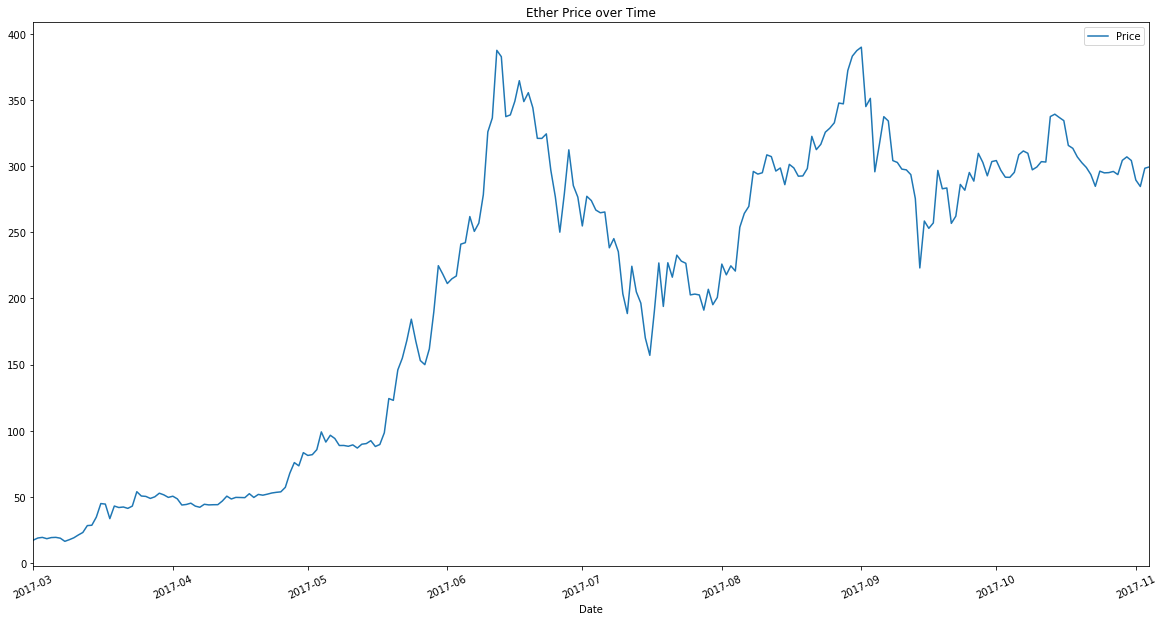

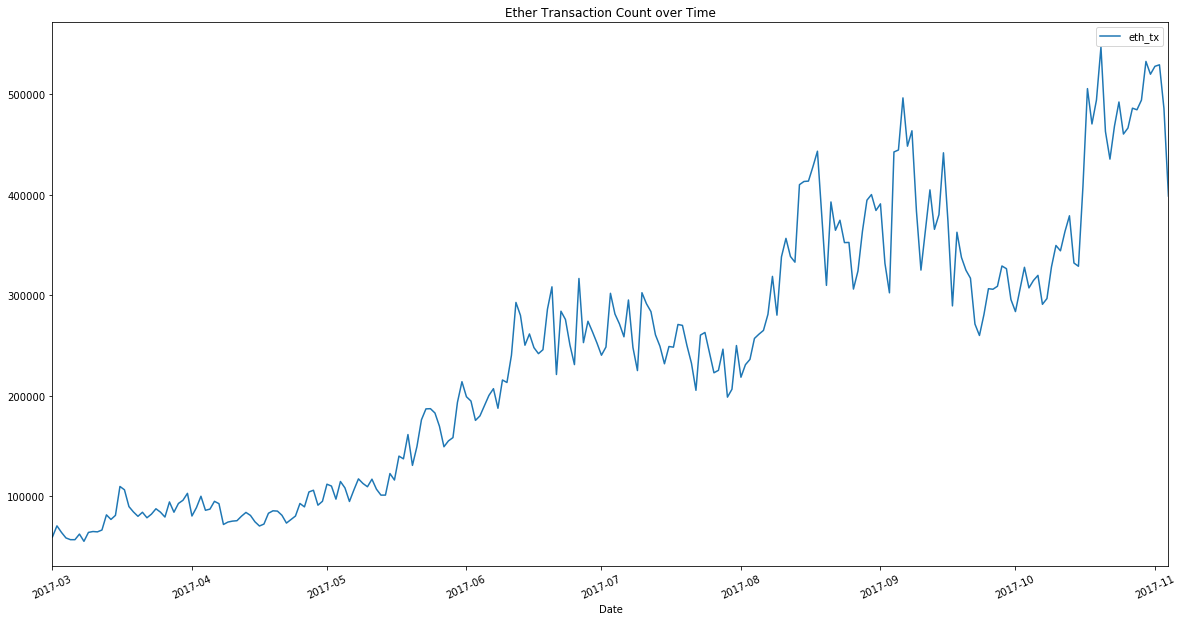

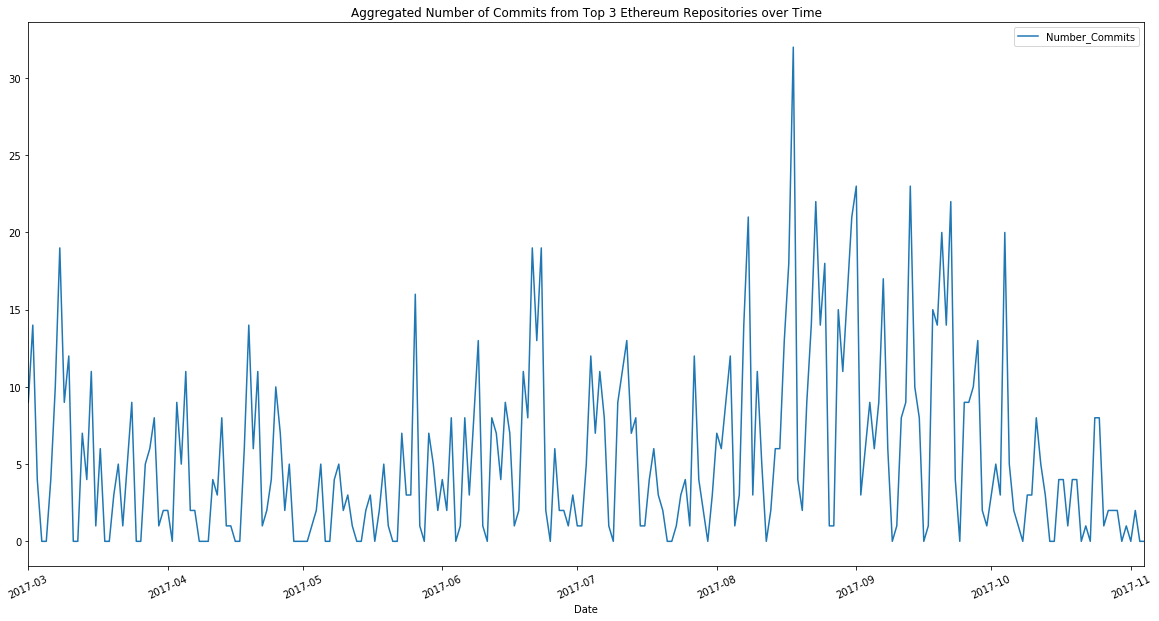

In [5]:
import matplotlib.pyplot as plt

df.plot(title='Ether Price over Time', x='Date', y='Price', rot=25, figsize=(20,10))
plt.show()
plt.close()

df.plot(title='Ether Transaction Count over Time', x='Date', y='eth_tx', rot=25, figsize=(20,10))
plt.show()
plt.close()

df.plot(title='Aggregated Number of Commits from Top 3 Ethereum Repositories over Time', x='Date', y='Number_Commits', rot=25, figsize=(20,10))
plt.show()
plt.close()

## Plot the Scatter Matrix

This will display the correlation between a pair of variables. (https://www.evl.uic.edu/aej/424/kyoung/Training-scatterplot.html)

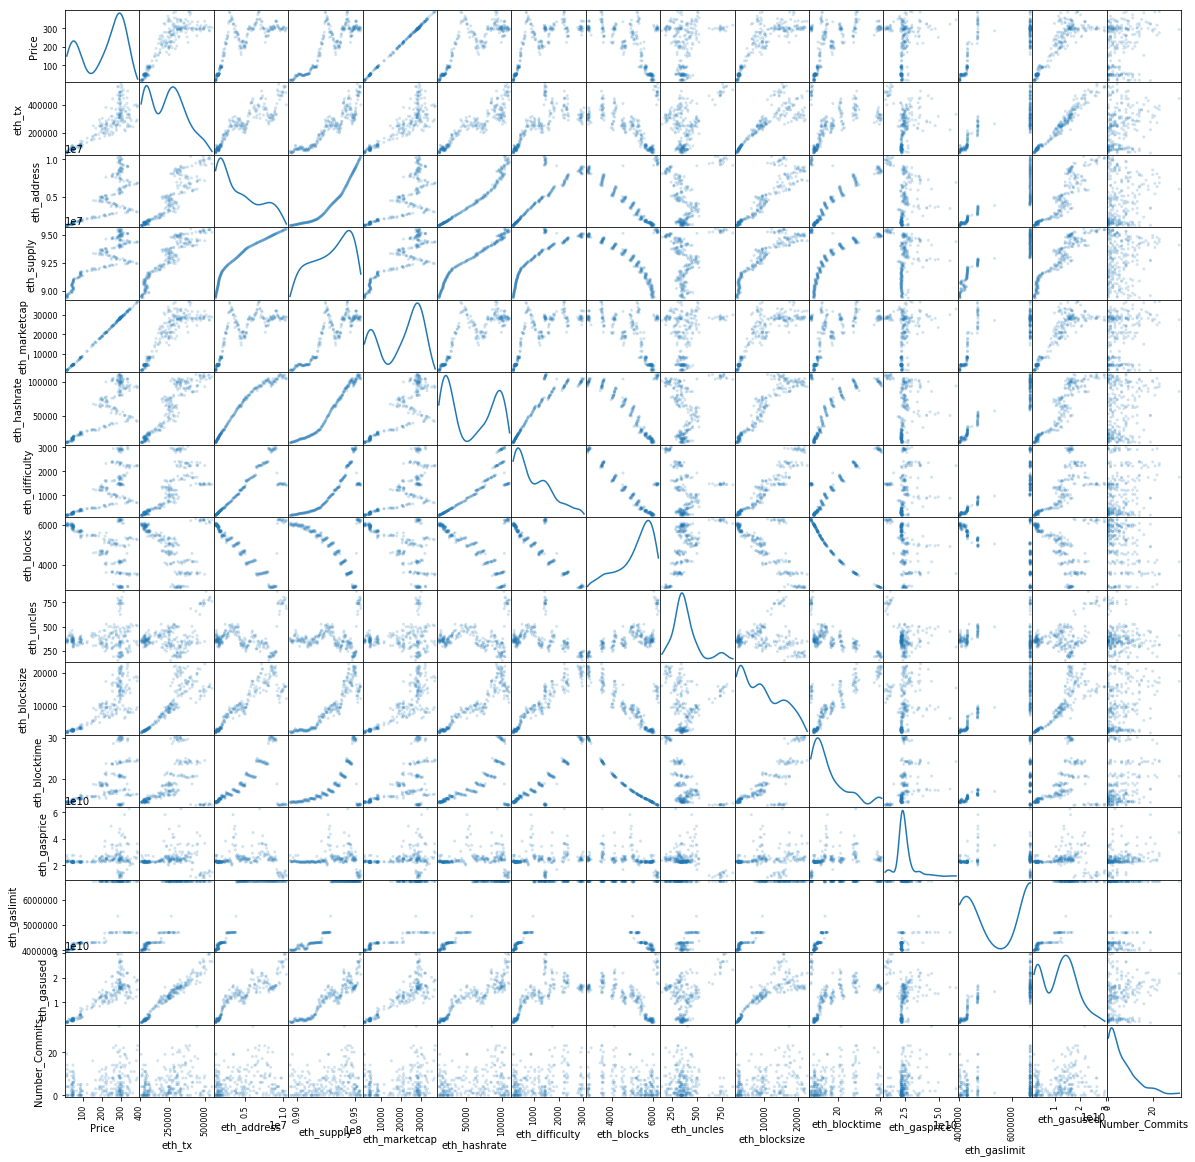

In [89]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(20,20), diagonal='kde')
plt.show()
plt.close()

## Plotting Features Against Each Other

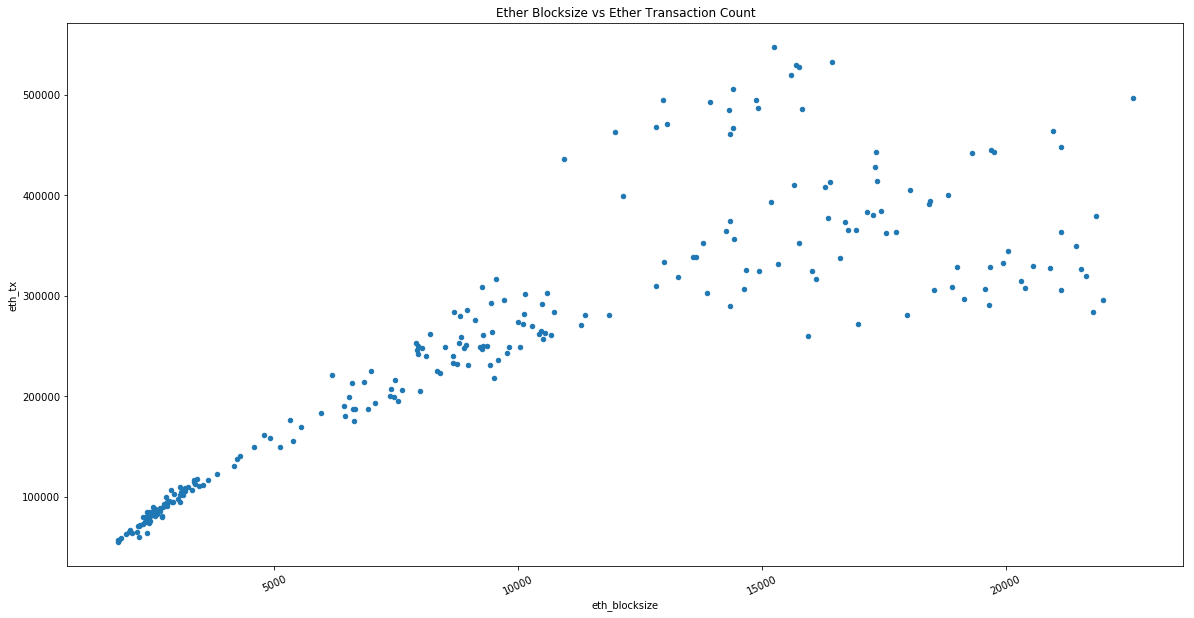

In [90]:
df.plot(title='Ether Blocksize vs Ether Transaction Count', x='eth_blocksize', y='eth_tx', rot=25, figsize=(20,10), kind='scatter')
plt.show()
plt.close()

* As ether gas limit increases, so does ether transaction count.
* Initially, there's a general trend that as eth_difficulty increases, so does ether transaction count. However, at around eth_difficuly 1,750, eth_tx count stops increasing. With eth_difficulty greater than 1,750, there's less transactions than if the difficulty was around 1,750.

## Normalize Data before PCA

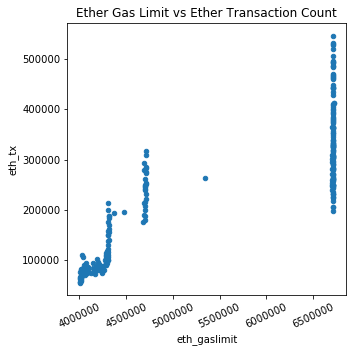

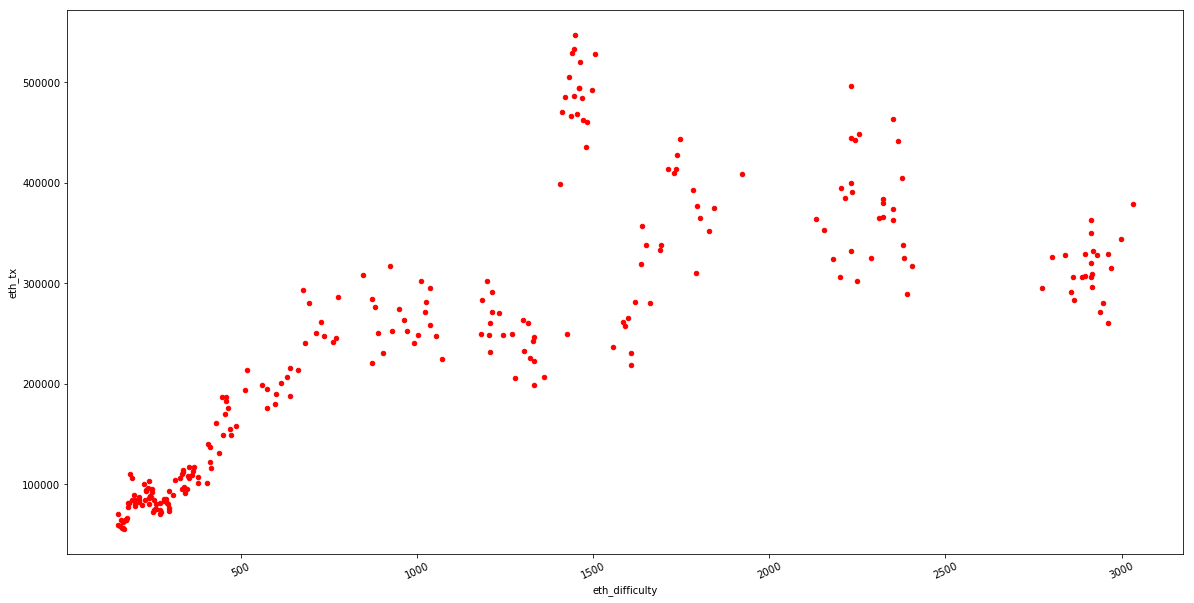

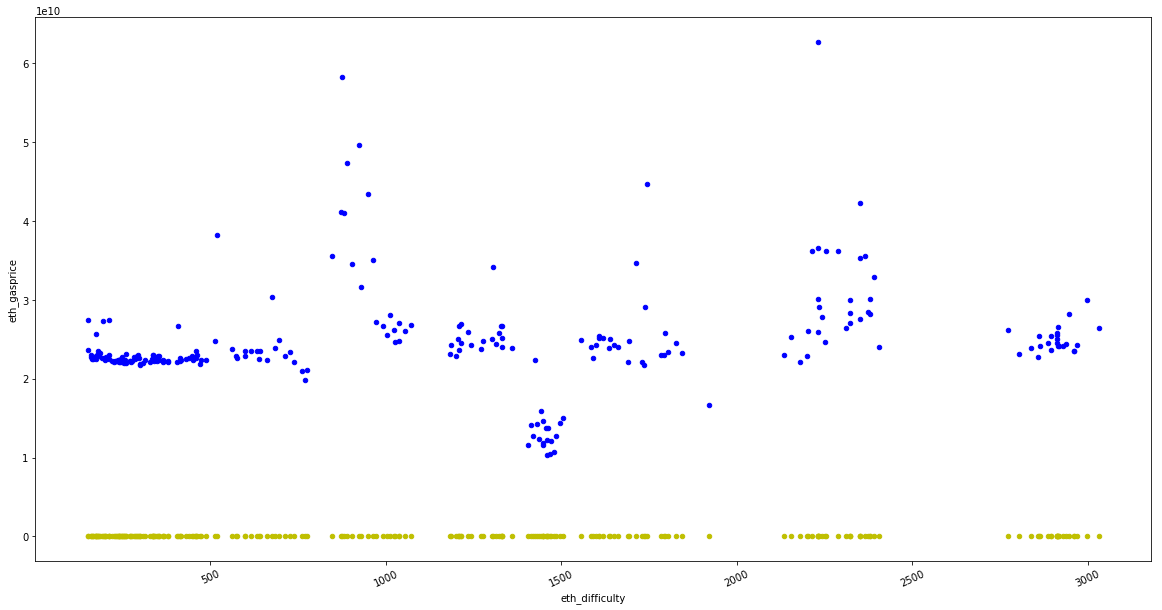

In [120]:
df.plot(title='Ether Gas Limit vs Ether Transaction Count', x='eth_gaslimit', y='eth_tx', rot=25, figsize=(5,5), kind='scatter')
plt.show()
plt.close()

# Refer to this https://pandas.pydata.org/pandas-docs/stable/visualization.html

'''
You can see the verticle gaps correspond to the commits. 
It's a bit interesting. Not sure if the commits would influence the price though.
'''

from sklearn.preprocessing import MinMaxScaler 

X_no_date = X.drop('Date', axis=1)
scaler = MinMaxScaler() 
X_no_date.groupby(['eth_tx','eth_hashrate', 'eth_difficulty', 'eth_blocksize','eth_gasprice']).apply(lambda x: scaler.fit_transform(x))

ax = X_no_date.plot(x='eth_difficulty', y='eth_tx', rot=25, figsize=(20,10), color='r', kind='scatter')
ax = X_no_date.plot(x='eth_difficulty', y='Number_Commits', rot=25, figsize=(20,10), color='y', kind='scatter')
X_no_date.plot(x='eth_difficulty', y='eth_gasprice', rot=25, figsize=(20,10), color='b', kind='scatter', ax=ax)
plt.show()
plt.close()

df.plot(title='Ether Blocksize vs Ether Transaction Count', x='eth_difficulty', y='eth_tx', rot=25, figsize=(5,5), kind='scatter', ax = ax)
plt.show()
plt.close()

[ 9.21352258  2.46888195  1.07814464  0.68775583  0.21909356]


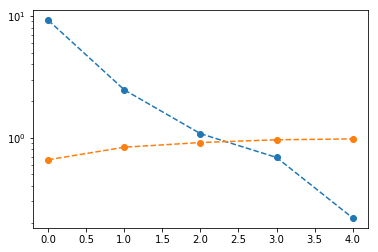

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_no_date = X.drop('Date', axis=1)
X_std = StandardScaler().fit_transform(X_no_date)
pca = PCA(n_components=5)
Y_sklearn = pca.fit_transform(X_std)
PCA().fit(Y_sklearn);
print(pca.explained_variance_) 

plt.semilogy(pca.explained_variance_, '--o')
plt.semilogy(pca.explained_variance_ratio_.cumsum(), '--o');
plt.show()
plt.close()

# Preprocessing
* Feature selection with PCA
    * Normalize the data before PCA
    * How do you transform it back to the way it was after normalization?
* TimeSeriesSplit of data

# Training

* Train with Bayesian Linear Regression classifier

# Testing

* Test it and confirm with the mean squared error

# Optimizing 

* Do I need more data points for the prediction to get better? - graph it
* Should I try using another model?